In [1]:
import numpy as np
from pytorch_tabnet.tab_model import TabNetRegressor


from sklearn.preprocessing import LabelEncoder
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt


import pandas as pd

#from distvis import plots as dplot

In [2]:
numerical_features = [
    'edad', 'meses_empleo'
]

categorical_features = [
    'sexo', 'rol_hogar', 'tipo_zona', 
    'termino_nivel', 'cine', 'est_conyugal', 'region', 'comuna', 'provincia',
    'est_subcontratado', 'categoria_empleo', 'grupo_ocupacion', 'nacionalidad'
]

features = categorical_features + numerical_features
target = "sueldo_neto"

In [3]:
datos = pd.read_csv('../datos/datos_procesados.csv').iloc[:, 1:]

test_index = datos.sample(frac=.1, random_state=1313).index
datos['is_test'] = 0 
datos.loc[test_index, 'is_test'] = 1

mean = np.log(datos.query('is_test == 0')[target]).mean()
std = np.log(datos.query('is_test == 0')[target]).std()

def transform(x):
    return (np.log(x) - mean)/std

def inv_transf(x):
    return np.exp(std*x + mean)

datos[target+'_transf'] = transform(datos[target])
datos[target+'_transf'].min(), datos[target+'_transf'].max()

df_train = datos.query('is_test == 0')
df_test = datos.query('is_test == 1')

df_test.loc[:, categorical_features] = df_test.loc[:, categorical_features].astype('category')
df_train.loc[:, categorical_features] = df_train.loc[:, categorical_features].astype('category')

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


<AxesSubplot:>

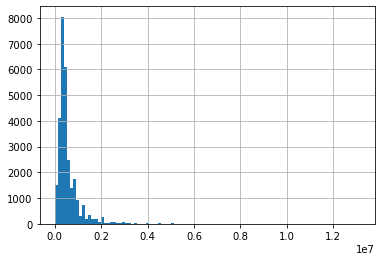

In [7]:
datos[target].hist(bins=100)

In [536]:
def get_categ_index_mapping(df_train, categ_feature):
    base_mapping = dict(zip(df_train[categ_feature], df_train[categ_feature].cat.codes + 1))
    return {**{"N/A": 0}, **base_mapping}

def get_categs_mappings(df_train, categs):
    mappings_list = []
    for i, c in enumerate(categs):
        map_dict = get_categ_index_mapping(df_train, c)
        mappings_list.append({'col': i, 'mapping': map_dict})
    return mappings_list

In [537]:
categs_mappings = get_categs_mappings(df_train, categorical_features)

In [10]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median', fill_value=np.NaN)), 
    ])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value="N/A")),
    ('label', OrdinalEncoder(handle_unknown="value", mapping=categs_mappings)), #uknown values goes to -1
    ('imputer_uknow', SimpleImputer(missing_values=-1, strategy='constant', fill_value=0)), #uknown values go to 0, the index for NaN
    ])

preprocessor = ColumnTransformer(               #preprocessor rearenge columns
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numerical_features)]
)


preprocessor.fit(df_train[features])

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='N/A',
                                                                strategy='constant')),
                                                 ('label',
                                                  OrdinalEncoder(mapping=[{'col': 0,
                                                                           'mapping': {'Hombre': 1,
                                                                                       'Mujer': 2,
                                                                                       'N/A': 0}},
                                                                          {'col': 1,
                                                                           'mapping': {'Conviviente': 1,
                                                                                       'Cónyuge': 

In [11]:
X_train = preprocessor.transform(df_train[features])
y_train = (df_train[target+'_transf']).values.reshape((-1, 1))

X_test = preprocessor.transform(df_test[features])
y_test = (df_test[target+'_transf']).values.reshape((-1, 1))

In [12]:
def get_emb_size_tio_jeremy(n_cat):
    return min(10, round(1.6 * n_cat**0.56))

In [13]:
cat_dims = [len(categs_mappings[i]['mapping']) for i, feature in enumerate(categorical_features)]
cat_idxs = [i for i, f in enumerate(features) if f in categorical_features]
cat_emb_dim = [get_emb_size_tio_jeremy(n_cat) for n_cat in cat_dims]

In [14]:
cat_emb_dim

[3, 6, 3, 3, 6, 5, 8, 10, 10, 3, 4, 6, 6]

In [560]:
regressor = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

Device used : cpu


In [562]:
%%time
max_epochs = 60
regressor.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'test'],
    eval_metric=['mae'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 0.93311 | train_mae: 0.71089 | test_mae: 0.70071 |  0:00:06s
epoch 1  | loss: 0.7237  | train_mae: 0.60011 | test_mae: 0.60711 |  0:00:12s
epoch 2  | loss: 0.62075 | train_mae: 0.55884 | test_mae: 0.57181 |  0:00:18s
epoch 3  | loss: 0.58669 | train_mae: 0.5468  | test_mae: 0.55632 |  0:00:24s
epoch 4  | loss: 0.5623  | train_mae: 0.52963 | test_mae: 0.53703 |  0:00:30s
epoch 5  | loss: 0.54205 | train_mae: 0.52128 | test_mae: 0.5269  |  0:00:35s
epoch 6  | loss: 0.52819 | train_mae: 0.51486 | test_mae: 0.52194 |  0:00:41s
epoch 7  | loss: 0.51607 | train_mae: 0.5062  | test_mae: 0.51381 |  0:00:47s
epoch 8  | loss: 0.50637 | train_mae: 0.50416 | test_mae: 0.51671 |  0:00:53s
epoch 9  | loss: 0.50039 | train_mae: 0.50267 | test_mae: 0.51241 |  0:00:59s
epoch 10 | loss: 0.49506 | train_mae: 0.49729 | test_mae: 0.50273 |  0:01:04s
epoch 11 | loss: 0.48842 | train_mae: 0.49203 | test_mae: 0.50078 |  0:01:11s
epoch 12 | loss: 0.48545 | train_mae: 0.49566 | test_mae: 0.5022

In [565]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', regressor)])

In [566]:
datos['sueldo_predicho'] = inv_transf(pipeline.predict(datos[features]))
datos['error'] = datos.eval('sueldo_predicho - sueldo_neto')
datos['error_porcentual'] = datos.eval('error/sueldo_neto')
datos['error_porcentual_abs'] = datos.eval('abs(error_porcentual)')

In [567]:
datos.query('is_test == 1')['error_porcentual_abs'].mean()

0.4769664323717556

In [568]:
datos.query('is_test == 1')['error_porcentual_abs'].median()

0.2578119848144381

In [544]:
import pyro
import pyro.distributions as dist
from pyro import poutine
from copy import copy

from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, TracePredictive
from pyro.optim import Adam
from pyro.infer import EmpiricalMarginal
from pyro.infer import Predictive
import torch
from pyro.nn.module import to_pyro_module_
from pyro.nn.module import PyroSample

In [574]:
scale = .1

def as_pyro_module(module):
    to_pyro_module_(module, recurse=True)
    for m in module.modules():
        for n, p in list(m.named_parameters(recurse=False)):
            #setattr(m, n, PyroSample(dist.Normal(torch.zeros_like(p), scale*torch.ones_like(p)).to_event()))
            setattr(m, n, PyroSample(dist.Normal(p, scale*torch.ones_like(p)).to_event()))
    return module

In [575]:
def get_predictions_pyro(model, guide, df, n_samples=25, varbls=['_RETURN']):
    
    x = torch.Tensor(preprocessor.transform(df[features]))
    
    predictive = Predictive(model, guide=guide, num_samples=n_samples, return_sites=varbls)
    samples_post = {v: predictive(x, None)[v].cpu().detach().numpy() for v in varbls}
    
    return samples_post

def get_test_metrics():
    valid_post = get_predictions_pyro(model, guide, df_test, n_samples=100)['_RETURN']
    q10 = np.quantile(valid_post, 0.1, axis=0)
    q90 = np.quantile(valid_post, 0.9, axis=0)
    metrics = {
        'coverage': ((y_test >= q10) & (y_test <= q90)).mean(),
        'diameter': ((inv_transf(q90) - inv_transf(q10))/inv_transf(y_test)).mean(),
        'mape':  (abs(inv_transf(valid_post.mean(axis=0).squeeze()) - df_test[target])/df_test[target]).mean(),
        'medianape': (abs(inv_transf(valid_post.mean(axis=0).squeeze()) - df_test[target])/df_test[target]).median(),
    }
    
    return metrics

In [576]:
device = regressor.device
one = torch.ones(1).to(device)
zero = torch.ones(1).to(device)

In [577]:
net = copy(regressor.network)
bayes_net = as_pyro_module(net)

In [578]:
batch_size = 1000

tabnet_centered = True

#original
def model(x, y=None):
    
    #define priors
    preds = net(x)[0]#.squeeze()
    sigma = one#pyro.sample('sigma', dist.Uniform(one*1e-1, one))
    
    #likelihood:
    if y is not None:
        with pyro.plate('observe_data', size=len(y), subsample_size=batch_size, device=device) as ind:
            pyro.sample('obs', dist.Normal(preds.index_select(0, ind), sigma).to_event(1), 
                        obs=y.index_select(0, ind))
    
    return preds

In [579]:
regressor.network(torch.Tensor(X_test))


(tensor([[ 0.4689],
         [-0.5440],
         [-0.2217],
         ...,
         [ 2.1726],
         [ 0.3693],
         [-0.7132]], grad_fn=<MmBackward>),
 tensor(-0.5958, grad_fn=<DivBackward0>))

In [582]:
regressor.predict(X_test)


array([[ 0.76307774],
       [-0.8460119 ],
       [-0.2459081 ],
       ...,
       [ 2.1346989 ],
       [ 0.27123162],
       [-0.38936874]], dtype=float32)

In [583]:
model(torch.Tensor(X_test))

tensor([[ 0.2112],
        [-0.5802],
        [-0.0348],
        ...,
        [ 1.7952],
        [ 0.2006],
        [-0.7489]], grad_fn=<MmBackward>)

In [584]:
guide = AutoDiagonalNormal(model)

In [585]:
optim = Adam({"lr": 0.005})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [586]:
%%time
X_train_torch = torch.Tensor(X_train)
y_train_torch = torch.Tensor(y_train)

pyro.clear_param_store()
num_iterations = 1000
metrics = []

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(X_train_torch, y_train_torch)
    metrics.append({**{'ELBO': loss}, **get_test_metrics()})
    
    if j % 2 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss))

[iteration 0001] loss: 31211.9849
[iteration 0003] loss: 32376.2596
[iteration 0005] loss: 31830.0645
[iteration 0007] loss: 32472.0106
[iteration 0009] loss: 30456.4404
[iteration 0011] loss: 31898.5070
[iteration 0013] loss: 32389.1269
[iteration 0015] loss: 30611.5730
[iteration 0017] loss: 32716.1973
[iteration 0019] loss: 31140.2530
[iteration 0021] loss: 30545.1022
[iteration 0023] loss: 31278.6649
[iteration 0025] loss: 31087.1652
[iteration 0027] loss: 31116.5416
[iteration 0037] loss: 30893.1208
[iteration 0039] loss: 32009.1149
[iteration 0041] loss: 31350.8539
[iteration 0043] loss: 30800.4051
[iteration 0045] loss: 30909.1706
[iteration 0047] loss: 30650.9035
[iteration 0049] loss: 34075.3869
[iteration 0051] loss: 31439.9966
[iteration 0053] loss: 31245.4943
[iteration 0055] loss: 30995.5796
[iteration 0057] loss: 30919.8857
[iteration 0059] loss: 31269.7298
[iteration 0061] loss: 30187.3333
[iteration 0063] loss: 30392.5500
[iteration 0065] loss: 30556.7180
[iteration 006

[iteration 0491] loss: 30442.7392
[iteration 0493] loss: 30547.5175
[iteration 0495] loss: 29628.6089
[iteration 0497] loss: 30408.5942
[iteration 0499] loss: 30288.8740
[iteration 0501] loss: 29525.4392
[iteration 0503] loss: 30703.9157
[iteration 0505] loss: 30542.3212
[iteration 0507] loss: 29905.7120
[iteration 0509] loss: 30311.1658
[iteration 0511] loss: 29635.0275
[iteration 0513] loss: 30870.1002
[iteration 0515] loss: 30420.4728
[iteration 0517] loss: 30494.3600
[iteration 0519] loss: 29740.1229
[iteration 0521] loss: 30860.8570
[iteration 0523] loss: 29981.2176
[iteration 0525] loss: 30082.7638
[iteration 0527] loss: 29805.9551
[iteration 0529] loss: 30397.0595
[iteration 0531] loss: 31077.8985
[iteration 0533] loss: 30592.9822
[iteration 0535] loss: 30218.2242
[iteration 0537] loss: 30234.0776
[iteration 0539] loss: 30325.8263
[iteration 0541] loss: 30284.9362
[iteration 0543] loss: 29685.1491
[iteration 0545] loss: 29379.3906
[iteration 0547] loss: 30610.0495
[iteration 054

[iteration 0973] loss: 30771.7159
[iteration 0975] loss: 30035.0975
[iteration 0977] loss: 29685.9871
[iteration 0979] loss: 30382.3908
[iteration 0981] loss: 30596.2840
[iteration 0983] loss: 30300.6105
[iteration 0985] loss: 31143.2226
[iteration 0987] loss: 30051.1347
[iteration 0989] loss: 30175.2645
[iteration 0991] loss: 30130.8060
[iteration 0993] loss: 30237.5706
[iteration 0995] loss: 30116.1087
[iteration 0997] loss: 30111.5361
[iteration 0999] loss: 29852.7705
CPU times: user 13h 1min 55s, sys: 56.6 s, total: 13h 2min 51s
Wall time: 3h 37min 59s


In [587]:
results = pd.DataFrame(metrics)

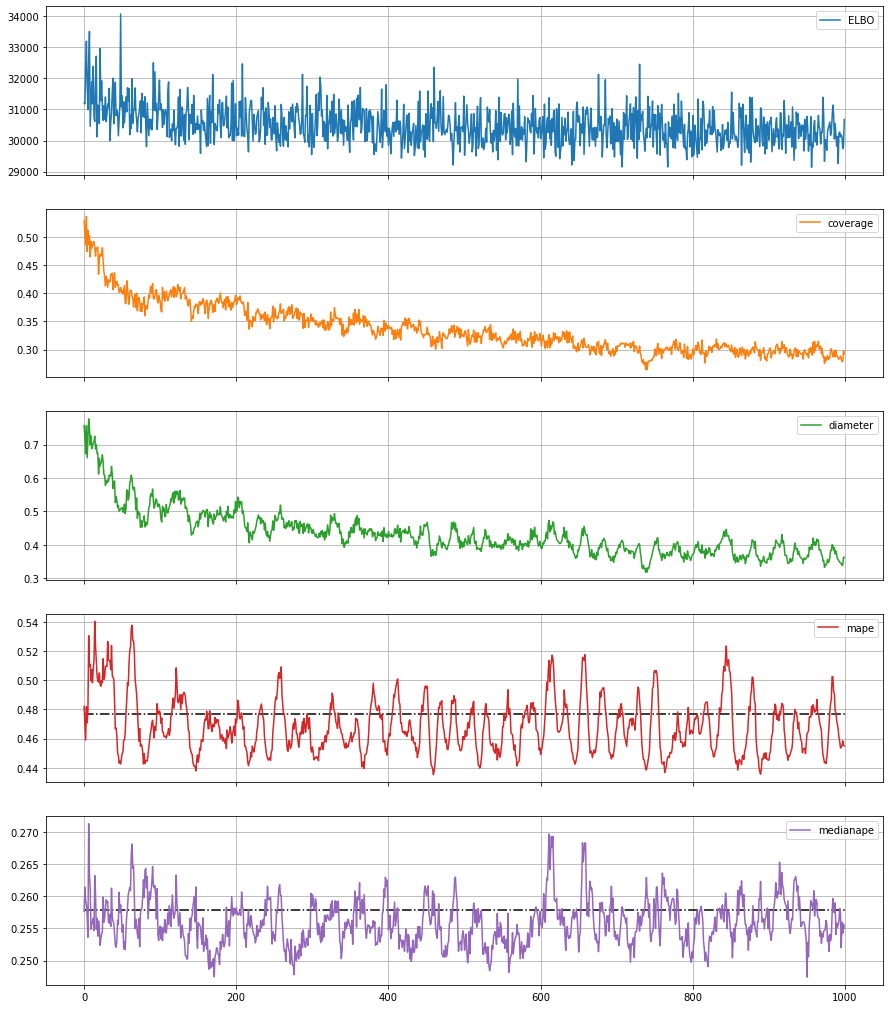

In [588]:
axes = results.plot(subplots=True, figsize=(15, 18),  grid=True)
axes[3].hlines(
    datos.query('is_test == 1')['error_porcentual_abs'].mean(), 
    xmin=0, xmax=len(metrics), color='k', linestyle='dashdot')
axes[4].hlines(datos.query('is_test == 1')['error_porcentual_abs'].median(), xmin=0, xmax=len(metrics), color='k', linestyle='dashdot')

Se pueden alcanzar resultados mejores usando el modelo promedio entrenado con SVI pero demomora mucho más 1 hr vs 6 mins. Por otro lado la calidad del intervalo de coonfianza del modelo no es muy buena ya que el coverage es de ~25% (teorico = 80%) y el diametro del intervalo es de un ~40%